# B(E2) analysis

Collect proton/neutron E2 matrix elements from runs using random samples of USDB

$ B(E2) = b^4 \left[ e_p M_p + e_n M_n \right]^2 $

Want to compute (approx) posterior distributions for oscillator length $b$, and effective charges $e_p$ and $e_n$ .

Prior assumptions:

$b^2 = 0.9 A^{1/3} + 0.7$

$P(e_p) \sim U[1,2]$

$P(e_n) \sim U[0,1]$


In [1]:
import numpy as np

import os
from glob import glob
from tqdm import tqdm
from time import time

def optimal_n_bins(y,max_bins=100):
    from scipy.stats import iqr
    n_bins = int((max(y) - min(y))/(2*iqr(y)*len(y)**(-1/3)))
    return min(n_bins,max_bins)

import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'serif'  : ['Palatino'],
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

import pandas as pd
import pickle as pkl

import sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:
from scipy.special import factorial2

# hbarc = 197.3 #MeV fm
# hbar = 6.582E-22 #MeV s
# alpha = 1/137
# mP = 938.272 # Mev/c^2
# #muN = 3.152E-14 # MeV / T
# muN2 =  alpha*hbarc**3*2*mP**-2 # nuclear magneton squared

hbarc = 197300 #keV fm
hbar = 6.582E-19 #keV s
alpha = 1/137
mP = 938272 # kev/c^2
#muN = 3.152E-14 # MeV / T
muN2 =  alpha*hbarc**3*2*mP**-2 # nuclear magneton squared


def Thalf_width(E): #converts energy width (MeV) to Thalf in seconds
    return hbar * np.log(2)/(E/1000)

def Thalf_width_kev(E):
    if E==0.:
        return None
    return Thalf_width(E)

def times_so_far(ls):
#     counts occurences of items
#     x = [0,2,1,0,4,2,2,1,0]
#     times_so_far(x) = [1, 1, 1, 2, 1, 2, 3, 2, 3]
    out = [0]*len(ls)
    for i in range(len(ls)):
        out[i] = ls[:i+1].count(ls[i])
    return out

def j_to_twoj(x):
    if '/2' in x:
        return int(x.strip('/2'))
    else:
        return 2*int(x.strip('()'))
    
def thalf_units_to_sec(units,value):
    m=0
    if units=='PS':
        m = 10**-12
    elif units=='NS':
        m = 10**-9
    elif units=='FS':
        m = 10**-15
    elif units=='US':
        m = 10**-6
    elif units=='AS':
        m = 10**-18
    elif units=='KEV':
        pass
    if m==0:
        return Thalf_width_kev(value)
    else:
        return m*value
    
def my_float(x):
    try:
        return float(x)
    except:
        return 0.0
    
def fLambda(l):
    return 8*np.pi*(l+1)/(l*(factorial2(2*l+1)**2))

def BEl(l,Egamma,Thalf,I,units):
    if units == 1: # [B] = fm^2l
        B = (I/100)*(np.log(2)/Thalf)*fLambda(l)**-1*hbar*hbarc**(2*l+1)*(Egamma**(-2*l-1))
    elif units == 2: # [B] = e^2 fm^2l
        B = (I/100)*(np.log(2)/Thalf)*fLambda(l)**-1*hbar*hbarc**(2*l+1)*(Egamma**(-2*l-1))
        B = B/(alpha*hbarc)
    elif units == 3: # [B] = e^2 b^l
        B = (I/100)*(np.log(2)/Thalf)*fLambda(l)**-1*hbar*hbarc**(2*l+1)*(Egamma**(-2*l-1))
        B = 10**(-2*l)*B/(alpha*hbarc)
    return B

def BE2_e2fm4(Egamma,Thalf,I):
    # in e^2 fm^4
    return BEl(2,Egamma,Thalf,I,2)

# def BE2_Wu(A,Egamma,Thalf,I):
#     lamW = 7.3E7*A**(4/3)*Egamma**5;
#     lamExp = (np.log(2)/(Thalf*10**-15))*(I/100);   #Thalf in fs
#     return lamExp/lamW

def Bweisskopf(l,A):
    # Weisskopf (single-particle) estimate in e^2 fm^2l
    return (1/(4*np.pi)) * (3/(3+l))**2 * (1.2*A**(1/3))**(2*l)

def BEl_in_Wu(l,Egamma,Thalf,I,A):
    return BEl(l,Egamma,Thalf,I,2) / Bweisskopf(l,A)
    

In [3]:
path_to_input_csv = 'sd_E2_processed_v2.csv'
path_to_usdb_csv = 'sd_E2_usdb_complete.csv'
df_input = pd.read_csv(path_to_input_csv)
df_usdb = pd.read_csv(path_to_usdb_csv)

In [4]:
df_input = df_input.rename(columns={'Unnamed: 0':'GlobalIndex'})
df_usdb = df_usdb.rename(columns={'Unnamed: 0':'GlobalIndex'})
# the key GlobalIndex comes from the original transition data

def drop_unnamed_columns(x):
    return x.loc[:, ~x.columns.str.contains('^Unnamed')]

df_input = drop_unnamed_columns(df_input)
df_usdb = drop_unnamed_columns(df_usdb)

In [5]:
usdbmil = np.loadtxt('/p/lustre2/fox39/shmuq/usdb/shmuq_e2/usdbmil.vec',skiprows=1)
usdb = np.loadtxt('/p/lustre2/fox39/shmuq/usdb/shmuq_e2/usdb.vec',skiprows=1)
n_params = len(usdb)

In [6]:
n_transitions = len(df_usdb)
print('# transitions =', n_transitions)

# transitions = 236


In [7]:
df_usdb.keys()

Index(['GlobalIndex', 'A', 'Element', 'Z', 'N', 'Energy (keV)',
       'Energy Unc (keV)', 'Ji', 'Thalf', 'E_gamma (keV)', 'E_gamma Unc (keV)',
       'I_gamma', 'I_gamma Unc', 'Mult', 'Mult Ratio', 'Mult Ratio Unc',
       'Conv Coef', 'Conv Coef Unc', 'B_exp (W.u.)', 'B_exp Unc (W.u.)',
       'twoJi', 'Thalf Value', 'Thalf Units', 'Thalf Unc', 'Thalf (sec)',
       'Thalf Unc (sec)', 'B_exp (e^2fm^4)', 'B_exp Unc (e^2fm^4)', 'Nucleus',
       'Jf', 'twoJf', 'ni', 'nf', 'Include', 'Mth_p', 'Mth_n'],
      dtype='object')

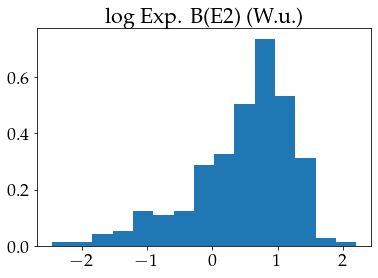

In [8]:
y = np.log10(df_usdb['B_exp (W.u.)'])
plt.hist(y, bins=optimal_n_bins(y), density=True)
plt.title('log Exp. B(E2) (W.u.)')
plt.show()

In [9]:
print(f'Out of {len(y)} transitions, {len(y[y<0])} are smaller than the Weisskopf estimate')

Out of 236 transitions, 53 are smaller than the Weisskopf estimate


### Excluding transitions

In [10]:
drop_nuc_list = ['17O','18O','17F','38Ar','38K']
for nuc in drop_nuc_list:
    df_usdb.at[df_usdb['Nucleus']==nuc,'Include'] = False

df_usdb.at[df_usdb['B_exp (W.u.)']<0.1,'Include'] = False
df_usdb.at[df_usdb['B_exp (W.u.)']>150.0,'Include'] = False
df_usdb.at[df_usdb['Mth_p'] == 0.0,'Include'] = False
df_usdb.at[df_usdb['Mth_n'] == 0.0,'Include'] = False

df_usdb = df_usdb[df_usdb['Include']==True]
n_transitions = len(df_usdb)
print(f'Number of transitions kept: {n_transitions}')

Number of transitions kept: 188


In [11]:
# b_sqr_vec = lambda A : 0.9*A**(1/3) + 0.7
b_sqr_vec = lambda A : 0.48*A**(1/3) + 1.91
single_particle_estimate = lambda A : Bweisskopf(2,A)

def Bth_model_v1(theta,A,Mth_p_vec,Mth_n_vec):
    e_p,e_n = theta
    Bth_vec = b_sqr_vec(A)**2 * ( e_p * np.array(Mth_p_vec) + e_n * np.array(Mth_n_vec))**2
    return Bth_vec

def Bth_model_Wu_v1(theta,A,Mth_p_vec,Mth_n_vec):
    return Bth_model_v1(theta,A,Mth_p_vec,Mth_n_vec) / single_particle_estimate(A)

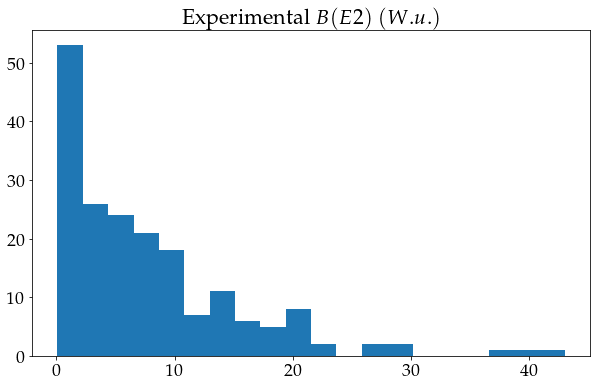

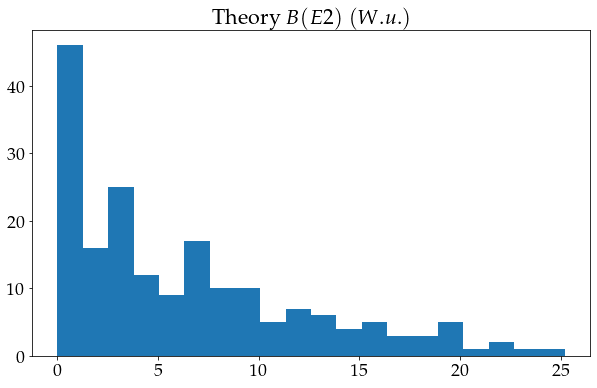

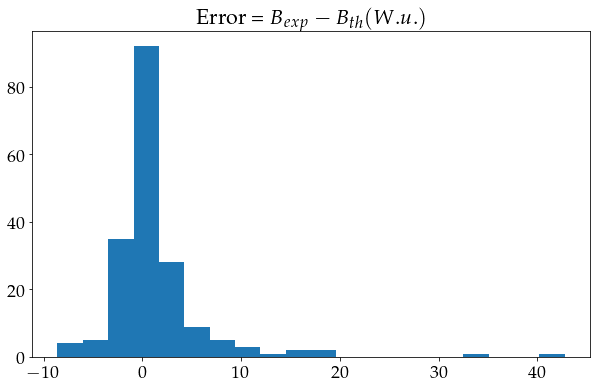

Error mean = 1.350080007357983
Error std = 5.459757251347516


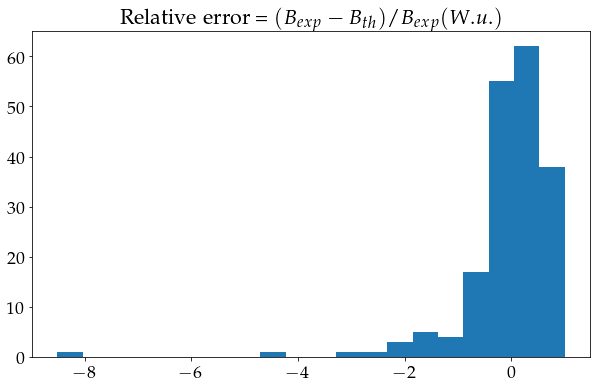

Relative error mean = -0.05837990223694759
Relative error std = 0.9718775656278246


In [12]:
A_vec = np.array(df_usdb['A'])
Bexp_Wu_vec = np.array(df_usdb['B_exp (W.u.)'])
Bexp_unc_Wu_vec = np.array(df_usdb['B_exp Unc (W.u.)'])
Mth_p_usdb_vec = np.array(df_usdb['Mth_p'])
Mth_n_usdb_vec = np.array(df_usdb['Mth_n'])
Bth_Wu_vec = Bth_model_Wu_v1((1.41,0.41),A_vec,Mth_p_usdb_vec,Mth_n_usdb_vec) 

fig = plt.figure(figsize=(10,6))
plt.hist(Bexp_Wu_vec,bins=20)
plt.title(r'Experimental $B(E2)$ $(W.u.)$ ')
plt.show()

fig = plt.figure(figsize=(10,6))
plt.hist(Bth_Wu_vec, bins=20) 
plt.title(r'Theory $B(E2)$ $(W.u.)$ ')
plt.show()

Berr_Wu_vec = Bexp_Wu_vec - Bth_Wu_vec
fig = plt.figure(figsize=(10,6))
plt.hist(Berr_Wu_vec,bins=20)
plt.title(r'Error = $B_{exp} - B_{th} (W.u.)$ ')
plt.show()
print(f'Error mean = {np.mean(Berr_Wu_vec)}')
print(f'Error std = {np.std(Berr_Wu_vec)}')

fig = plt.figure(figsize=(10,6))
plt.hist(Berr_Wu_vec/Bexp_Wu_vec,bins=20)
plt.title(r'Relative error = $(B_{exp} - B_{th})/B_{exp} (W.u.)$ ')
plt.show()
print(f'Relative error mean = {np.mean(Berr_Wu_vec/Bexp_Wu_vec)}')
print(f'Relative error std = {np.std(Berr_Wu_vec/Bexp_Wu_vec)}')

     fun: 4.5372648752193775e-17
    nfev: 17
     nit: 10
 success: True
       x: 4.054741089507722


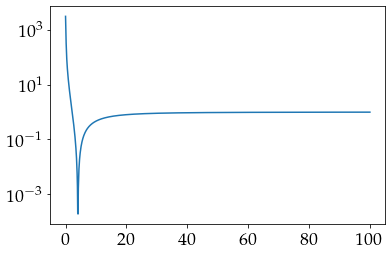

In [15]:
from scipy.optimize import minimize, minimize_scalar, dual_annealing, brute

def chi_squared(theta,sigmaB_apriori):
    sqr_errors = (Bexp_Wu_vec - Bth_model_Wu_v1(theta,A_vec,Mth_p_usdb_vec,Mth_n_usdb_vec))**2
    B_unc_sqr_vec = np.array( [(sigmaB_apriori**2 + sigmaB**2) for sigmaB in Bexp_unc_Wu_vec])
    R_sqr =  sqr_errors / B_unc_sqr_vec
    return  np.sum(R_sqr)

def obj(sigmaB_apriori):
#     theta_0 = 1.64, 0.45
    theta_0 = 1.41,0.41
    X2 = chi_squared(theta_0,sigmaB_apriori)
    dof = n_transitions - n_params
    return (1-(X2/dof))**2

# opt_result = minimize(obj,x0=4, bounds = [(0.1,20)])
# opt_result = dual_annealing(obj, bounds=[(0.,100.)])
# opt_result = brute(obj,ranges=[(0.,10.)], Ns=10**3, workers=-1)
opt_result = minimize_scalar(obj)
print(opt_result)

x = np.linspace(0,100,1000)
y = np.array([obj(q) for q in x])
plt.semilogy(x,y)
plt.show()

In [16]:
sigmaB_apriori = opt_result.x
print(f'A priori B(E2) uncertainty (W.u.) = {sigmaB_apriori}')

A priori B(E2) uncertainty (W.u.) = 4.054741089507722
